# RCC Stages Feature Selection and Preliminary Prediction

Author: Olatomiwa Bifarin<br>
Department of Biochemistry and Molecular Biology<br>
University of Georgia<br>
Edison Lab<br>

Last edited: 30JUNE2020

_This is a static version of a Jupyter notebook, and work (documentation) is still in progress_ 

**Goal**: To predict early and late stage RCC using urine-based metabolomics <br>

**Update**: Other machine learning methods including ensemble learning were used to predict RCC staging, and as such great improvement were made from the previous predictions.

### Notebook Outline

1. [Load Data](#1)
2. [Feature Selection](#2)
3. [RCC Stage Prediction](#3)
4. [RCC Stage Potential Biomarkers: PCA, HCA, Boxplot Visualization](#4)
5. [Patient Cohort Characteristics and Confounder Analysis](#5)

In [ ]:
#import python packages and libraries
import csv
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import style
import scipy
from scipy import stats
from statsmodels.formula.api import ols
import statsmodels as sms
from statsmodels.stats import multitest
from scipy.stats import shapiro
from decimal import Decimal
from statistics import mean
#For Seaborn plots
import seaborn as sns; sns.set(style='white')

#To ignore warning
import warnings
warnings.filterwarnings('ignore')

# More sharp and legible graphics
%config InlineBackend.figure_format = 'retina'

# Set seaborn figure labels to 'talk', to be more visible. 
sns.set_context('talk')

# Import machine learning libraries
# Test train split and K-fold validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
# Random Forest
from sklearn.ensemble import RandomForestRegressor
# Gradient Boosting
from sklearn.ensemble import GradientBoostingRegressor

from sklearn import preprocessing
# Scaling 
from sklearn.preprocessing import StandardScaler
# Recursive Feature Elimination
from sklearn.feature_selection import RFECV

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier

# Import Random Forest classifier, sklearn metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# test train split and K-fold validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn import decomposition

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

## 1. Load Data (all data)
<a id="1"></a>

In [ ]:
RCCdataframe = pd.read_excel('data/RCCdataframe.xlsx')
# Remove samples with inconclusive staging information.
RCCdataframe = RCCdataframe[pd.notnull(RCCdataframe['Grouped Stage'])]

In [ ]:
# non-metabolites (non-features) elements in RCC dataframe
non_metabolites = ['Groups', 'Collection', 'Sample ID', 'Metastatic', 
     'SubTypes','Nuclear Grade', 'Grade', 'Tstage', 
     'Tstage Group', 'Nstage', 'Mstage', 
     'Stage', 'Grouped Stage','Tumor Width','Gender', 
     'Race', 'BMI', 'Smoker', 'Age', 'Patient ID' ]

In [ ]:
# df_features contains the features alone. 
df_features = RCCdataframe.drop(non_metabolites, axis=1)

## 2. Feature Selection
<a id="2"></a>

Stage I and II RCC were classified as Early RCC, while Stage III and IV as Late RCC

In [ ]:
RCCdataframe['Grouped Stage'].value_counts()

Early    41
Late     29
Name: Grouped Stage, dtype: int64

### a. Select features with greater than 2-fold changes

In [ ]:
# Define two dataframes, Early RCC cancer and Late RCC cancer, and drop
# non-metabolites features from these dataframes.

Early = RCCdataframe[(RCCdataframe['Grouped Stage'] == 'Early')].drop(non_metabolites,
                                                                      axis=1)
Late = RCCdataframe[(RCCdataframe['Grouped Stage'] == 'Late')].drop(non_metabolites,
                                                                      axis=1)

In [ ]:
dfmean = pd.DataFrame({'Features':df_features.columns, 
                       'Control':Early.mean(axis=0).values,
                       'RCC':Late.mean(axis=0).values})
dfmean.shape

(7145, 3)

In [ ]:
cols = []
ctr_val = dfmean['Control']
rcc_val = dfmean['RCC']

for ctr, rcc in zip(ctr_val, rcc_val):
    ratio1 = ctr/rcc
    ratio2 = rcc/ctr
    if ratio1 > 2:
        feature = dfmean[dfmean['Control']==ctr]['Features'].values.tolist()
        cols.append(feature)
    elif ratio2 > 2:
        feature = dfmean[dfmean['Control']==ctr]['Features'].values.tolist()
        cols.append(feature)
xfold_feat = [val for sublist in cols for val in sublist] # flatten out list of list.
len(xfold_feat)

1498

### b. _t_-Test Feature Selection

___T-test function___

In [ ]:
def Ttest(metabolites, dfControl, dfTreat, alpha=0.05, var=True):
    '''
    Function conducts a T-test for the metabolites differences between two groups with 
    Benjamini-Hocberg FDR correction
    
    Inputs: 
    metabolites = A list containing names of metabolites
    dfControl = A pandas dataframe containing the control group metabolites data
    dfTreat =  A pandas dataframe containing the treatment group metabolites data
    alpha = alpha for statistical significant judgment, default 0.05
    var = If True (default), perform a standard independent 2 sample test that assumes 
    equal population variances [1]. If False, perform Welch’s t-test, which does not 
    assume equal population variance
    
    Outputs: A pandas dataframe with p-values of numerical cohort characteristics. 
    
    '''
    ttest_dict = {}
    for metabolite in metabolites:
        statistic, pvalue =  scipy.stats.ttest_ind(dfControl[metabolite], 
                                               dfTreat[metabolite], 
                                               equal_var=var)
        ttest_dict[metabolite] = pvalue 
        # a dictionary containing name of metabolites and p value after t-test
    ttest = pd.DataFrame.from_dict(ttest_dict, orient='index') # the dictionary in pandas df
    ttest_list=list(ttest_dict.values()) #values (pvalues) of ttest result in a list
    reject, pval_corrected, _, _ = sms.stats.multitest.multipletests(ttest_list, 
                                                                 alpha=alpha, 
                                                                 method='fdr_bh')
    ttest_results = pd.DataFrame({'Metabolite': metabolites, 'T-test p-value': ttest_list, 
                              'FDR p-value': pval_corrected, 'Reject H0': reject})
    Table = ttest_results.sort_values(by=['FDR p-value'])
    return Table

In [ ]:
# '''List of final metabolites set'''
metabolite_list = xfold_feat

# '''List of final metabolites set'''
ttest_result = Ttest(metabolite_list, Early, Late, alpha=0.05, var=False)

# '''List of Statistically relevant metabolites'''
# Select metabolites with <0.05 FDR
#stat_sig = ttest_result.loc[ttest_result['Reject H0'] == True]

# Select metabolites with <0.05 t-test
stat_sig = ttest_result.loc[ttest_result['T-test p-value'] <= 0.05]
print("The total number of significant metabolites/Features is: ", len(stat_sig))

The total number of significant metabolites/Features is:  171


In [ ]:
Feature = stat_sig['Metabolite'].values.tolist(); # stat MS significant metabolites
# p<0.05 metabolites and remove samples with inconclusive staging information.
MLfeatures = RCCdataframe[Feature]
#MLfeatures = dummydf[MSEA_Query['Query']] # All MSEA metabolites
MLfeatures =(MLfeatures - MLfeatures.mean(axis=0))/MLfeatures.std(axis=0) #autoscaling
MLfeatures.shape

(70, 171)

_Remove highly correlated features (Optional): Works best WITH this step_

In [ ]:
correlated_features = set()
correlation_matrix = MLfeatures.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
MLfeatures = MLfeatures.drop(correlated_features, axis=1)
MLfeatures.shape

(70, 99)

### PLSRegression for Feature Selection

Reference: 
-  https://nirpyresearch.com/variable-selection-method-pls-python/
-  https://github.com/scikit-learn/scikit-learn/issues/7050
-  https://scikit-learn.org/stable/modules/generated/sklearn.cross_decomposition.PLSRegression.html

In [ ]:
dfgrp = RCCdataframe.filter(['Grouped Stage'], axis=1)
# convert strings (RCC, Control) to integers
dfgroup = dfgrp['Grouped Stage'].map({'Early': 0, 'Late': 1}) 
# Features and groups
X = MLfeatures.values
y = dfgroup.values

In [ ]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
pls = PLSRegression()
pls.fit(X, y)

PLSRegression(copy=True, max_iter=500, n_components=2, scale=True, tol=1e-06)

*PLS coefficient of the fit*

In [ ]:
def vip(x, y, model):
    t = model.x_scores_
    w = model.x_weights_
    q = model.y_loadings_

    m, p = x.shape
    _, h = t.shape

    vips = np.zeros((p,))

    s = np.diag(t.T @ t @ q.T @ q).reshape(h, -1)
    total_s = np.sum(s)

    for i in range(p):
        weight = np.array([ (w[i,j] / np.linalg.norm(w[:,j]))**2 for j in range(h) ])
        vips[i] = np.sqrt(p*(s.T @ weight)/total_s)

    return vips

In [ ]:
vip_list = vip(X, y, pls.fit(X, y))

In [ ]:
list_of_tuples = list(zip(MLfeatures.columns, vip_list))
df_feat = pd.DataFrame(list_of_tuples, columns = ['Metabolites', 'Importance'])
df_feat = df_feat.sort_values(by='Importance', ascending=False)
#df_feat = df_feat.loc[df_feat['Ranking'] == True]
df_feat.head()

,Metabolites,Importance
3,248,1.418307
2,5408,1.412318
41,5898,1.401496
97,2085,1.306617
11,5045,1.305475


In [ ]:
# top 35 ML PLS features: Check for experiment below:
PLSfeatures = RCCdataframe[df_feat['Metabolites'][:35].tolist()].columns 

### Recursive Feature Elimination for Feature Selection

Optimal number of features : 89


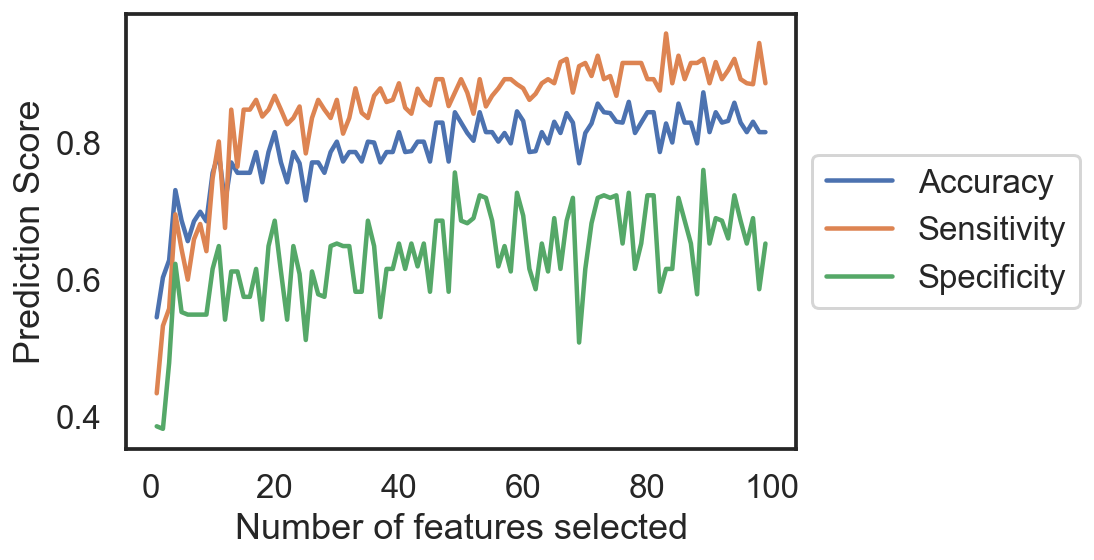

In [ ]:
# Create the RFE object and compute a cross-validated score.
#RF= RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, class_weight="balanced",  random_state=42)
RF=RandomForestClassifier(n_estimators=100, random_state=42)

# The "accuracy" scoring is proportional to the number of correct
# classifications
accuracy = RFECV(estimator=RF, scoring='accuracy') #'accuracy'
precision = RFECV(estimator=RF, scoring='precision') #'accuracy'
recall = RFECV(estimator=RF, scoring='recall') #'accuracy'

accuracy.fit(X, y)
precision.fit(X, y)
recall.fit(X,y)

print("Optimal number of features : %d" % accuracy.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Prediction Score")
plt.plot(range(1, len(accuracy.grid_scores_) + 1), 
         accuracy.grid_scores_, label='Accuracy')
plt.plot(range(1, len(precision.grid_scores_) + 1), 
         precision.grid_scores_, label='Sensitivity')
plt.plot(range(1, len(recall.grid_scores_) + 1), 
         recall.grid_scores_, label='Specificity')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [ ]:
print ("The highest accuracy features is {}%" .format(max(accuracy.grid_scores_)*100))

The highest accuracy features is 87.24747474747475%


Rank features by the features importance from `RF-RFECV` algorithms. 

In [ ]:
list_of_tuples = list(zip(MLfeatures.columns, 
                          accuracy.estimator_.feature_importances_, 
                          accuracy.support_, accuracy.ranking_))
df_feat = pd.DataFrame(list_of_tuples, columns = ['Metabolites', 'Importance', 
                                                  'Selected', 'Ranking'])
df_feat = df_feat.sort_values(by='Importance', ascending=False)
#df_feat = df_feat.loc[df_feat['Ranking'] == True]
df_feat.head()

,Metabolites,Importance,Selected,Ranking
4,5255,0.038118,False,11
16,1904,0.035878,True,1
3,248,0.033527,True,1
38,4947,0.029678,True,1
5,3163,0.027525,True,1


### Experiment to determine the top features to select for prediction.

| Top _x_ PLSDA & RFECV|Overlapping features|Best Model|AUC|Accuracy|Sensitivity|Specificity|
|--|--|--|--|--|--|--|
|10|3|k-NN|0.80|77%|71%|71%|
|20|9|SVM-RBF|0.80|80%|69%|88%|
|30|13|SVM-RBF|0.82|80%|73%|85%|
|35|18|SVM-RBF|0.90|84%|80%|88%|

For this experiment: Random Forest, SVM-RBF, SVM-Lin, and k-NN were used

Hence I select the top 35 criteria. <br>

_Select the features with the top 35 RF feature importance score_

In [ ]:
# top 20 ML PLS features
RFfeatures = RCCdataframe[df_feat['Metabolites'][:35].tolist()].columns 

#### Converge the PLS-DA and RF features.

In [ ]:
final_features = set(PLSfeatures) - (set(PLSfeatures) - set(RFfeatures))
final_features

{248,
 1372,
 1904,
 2122,
 2317,
 2465,
 3163,
 3766,
 4116,
 5045,
 5408,
 5420,
 5437,
 5713,
 5737,
 5985,
 6687,
 6694}

In [ ]:
MS_labels = pd.read_excel('data/MS_labels.xlsx')

In [ ]:
MS_labels[MS_labels.ID.isin(final_features)]

,ID,Mode,RT [min],Name,Formula
247,248,positive,5.127,248,NaN
1371,1372,positive,3.941,4-Guanidinobutanoate,C5 H11 N3 O2
1903,1904,positive,4.004,7-Aminomethyl-7-deazaguanine,C7 H9 N5 O
2121,2122,positive,1.209,Nalpha_Nalpha-Dimethyl-L-histidine,C8 H13 N3 O2
2316,2317,positive,0.892,Diethyl2-methyl-3-oxosuccinate,C9 H14 O5
2464,2465,positive,0.893,1-Carbapen-2-em-3-carboxylicacid,C7 H7 N O3
3162,3163,positive,3.530,3163,C5 H15 N10 O2 P
3765,3766,positive,3.633,L-Indospicine,C7 H15 N3 O2
4115,4116,positive,3.799,4116,NaN
5044,5045,negative,3.496,5045,C7 H9 N O5 S


In [ ]:
MLfeatures = RCCdataframe[list(final_features)]
MLfeatures =(MLfeatures - MLfeatures.mean(axis=0))/MLfeatures.std(axis=0) #autoscaling

In [ ]:
X = MLfeatures.values
X;

## 3. Machine Learning for RCC (Early vs Late) Prediction
<a id="3"></a>

_Machine Learning Model Function_

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn import model_selection

In [ ]:
def ml_model(X, y, model, kfold=5):
    
    '''
    FUNCTION: 
    A  machine learning function under Kfold cross validation conditions  
    
    DEPENDENCY: 
    Various Sklearn packages
    from sklearn import metrics
    from sklearn.model_selection import train_test_split
    from sklearn.model_selection import KFold
    from sklearn.metrics import roc_curve, auc
    from sklearn.metrics import roc_auc_score
    
    INPUTS: 
    X = numpy.ndaarray: features
    y = numpy.ndaarray: Labels encoded as 0s and 1s. 
    model = machine learning model
    kfold = numeric. K-fold default is 5. 
    
    OUTPUT: 
    A list containing the following machine learning metrics: 
    Area Under the Curve(AUC), Accuracy (ACC), Precision (PRE), 
    Recall (REC), F1-core (FS), Matthew's Correlation Coefficient (MCC). 
    
    '''

    cv = model_selection.StratifiedKFold(n_splits=kfold, random_state=42, shuffle=True)
    # define 'list' of various metrics
    AUC, ACC, PRE, REC, FS, MCC, SPE = [], [], [], [], [], [], [] 
    performance = []
    
    for (train, test), i in zip(cv.split(X, y), range(kfold)):
        # training the model
        model.fit(X[train], y[train])
        y_pred = model.predict(X[test])
        
        #Retrieving metrics after testing
        modelprobs = model.predict_proba(X[test])
        fpr, tpr, thresholds = metrics.roc_curve(y[test], modelprobs[:,1])
        roc_auc = auc(fpr, tpr)
        accuracy = metrics.accuracy_score(y[test], y_pred)
        precision = metrics.precision_score(y[test], y_pred)
        recall = metrics.recall_score(y[test], y_pred)
        f1_score = metrics.f1_score(y[test], y_pred)
        mcc = metrics.matthews_corrcoef(y[test], y_pred)
        # coding specificity
        tn, fp, fn, tp = confusion_matrix(y[test], y_pred).ravel()
        specificity = tn / (tn+fp)
        # append metrics to list
        AUC.append(roc_auc)
        ACC.append(accuracy)
        PRE.append(precision)
        REC.append(recall)
        FS.append(f1_score)
        MCC.append(mcc)
        SPE.append(specificity)
    return AUC, ACC, PRE, REC, FS, MCC, SPE

_Machine Learning Metric Plot Function_

In [ ]:
def MLmetric_plot(data_dict, y_label):
    '''
    FUNCTION: 
    To plot machine learning metrics from ml_model function.   
    
    DEPENDENCY: 
    Pandas, seaborn, 
    
    INPUTS: 
    data_dict = dictionary. Contains ML model name and metric scores
    y_label = String. Label for the y-axis 
    
    OUTPUT: 
    Figure
    
    '''
    
    fig = pd.DataFrame(data=data_dict)
    splot = sns.barplot(x='Model', y=y_label, data=fig);
    #splot = sns.swarmplot(data=ACCfig, orient='h', s=10, alpha=0.7, color=".25");
    for p in splot.patches:
        splot.annotate(format(p.get_height(), '.2f'), 
                              (p.get_x() + p.get_width() / 2., p.get_height()), 
                              ha = 'center', va = 'center', xytext = (6, 15), 
                              textcoords = 'offset points')
    return splot
#plt.savefig('testACC.svg', dpi=300)



Train with various machine learning models.

### Experiment with ML algorithm for prediction.

| ML Algorithm| AUC | Accuracy | Sensitivity | Specificity|
| -- | -- | -- | -- | -- |
| ___Random Forest___ | 0.86 | 77% | 69% | 83% |
| ___k-NN___ | 0.82 | 75% | 55% | 90% |
| ___SVM-RBF___ | 0.90 | 84% | 80% | 80% |
| ___SVM-Lin___ | 0.88 | 77% | 66% | 85% |
| ___Naive Bayes___ | 0.88 | 83% | 80% | 85% |
| ___AdaBoost___ | 0.80 | 77% | 75% | 78% |
| ___Logistic Regression___ | 0.92 | 84% | 76% | 90% |

Logistic regression, SVM-RBF, Naive Bayes, and AdaBoost were selected for the paper.

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

In [ ]:
## Try Naive Bayes
NB = GaussianNB()
#NB = MultinomialNB()

metric = ml_model(X, y, NB)
NB_AUC, NB_ACC, NB_PRE, NB_REC, NB_FS, NB_MCC, NB_SPE = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5], metric[6]

# AdaBoost Classifier
ADA = AdaBoostClassifier(random_state=42)
metric = ml_model(X, y, ADA)
ADA_AUC, ADA_ACC, ADA_PRE, ADA_REC, ADA_FS, ADA_MCC, ADA_SPE = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5], metric[6]

# Logistic Regression
LR = LogisticRegression(solver="liblinear", random_state=42)
metric = ml_model(X, y, LR)
LR_AUC, LR_ACC, LR_PRE, LR_REC, LR_FS, LR_MCC, LR_SPE = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5], metric[6]

# SVM
#clf = svm.SVC(kernel='linear', probability=True)
clf = svm.SVC(kernel = 'rbf', probability=True, random_state=42)
metric = ml_model(X, y, clf)
clf_AUC, clf_ACC, clf_PRE, clf_REC, clf_FS, clf_MCC, clf_SPE = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5], metric[6]

# Voting Classifiers
# vclf = VotingClassifier(
#    estimators=[('nb', NB), ('ada', ADA), 
#                ('lr', LR), ('clf', clf)],
#    voting='hard')

# metric = ml_model(X, y, vclf)
# vclf_AUC, vclf_ACC, vclf_PRE, vclf_REC, vclf_FS, vclf_MCC, vclf_SPE = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5], metric[6]



**AUC**

In [ ]:
sns.set_context('talk', font_scale=0.8)

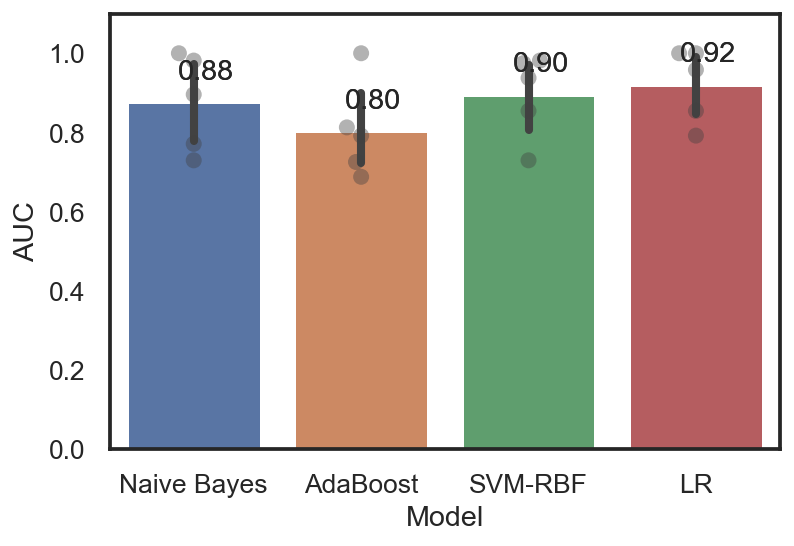

In [ ]:
AUCfig = {'Model': ['Naive Bayes', 'AdaBoost', 'SVM-RBF', 'LR'], 
               'AUC':[mean(NB_AUC), mean(ADA_AUC), mean(clf_AUC), mean(LR_AUC)]}

afig = {'Naive Bayes': NB_AUC, 'AdaBoost': ADA_AUC, 
        'SVM-RBF': clf_AUC, 'LR': LR_AUC}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(AUCfig, 'AUC');
#plt.title('ML Model AUC Comparison for RCC prediction');

**Accuracy**

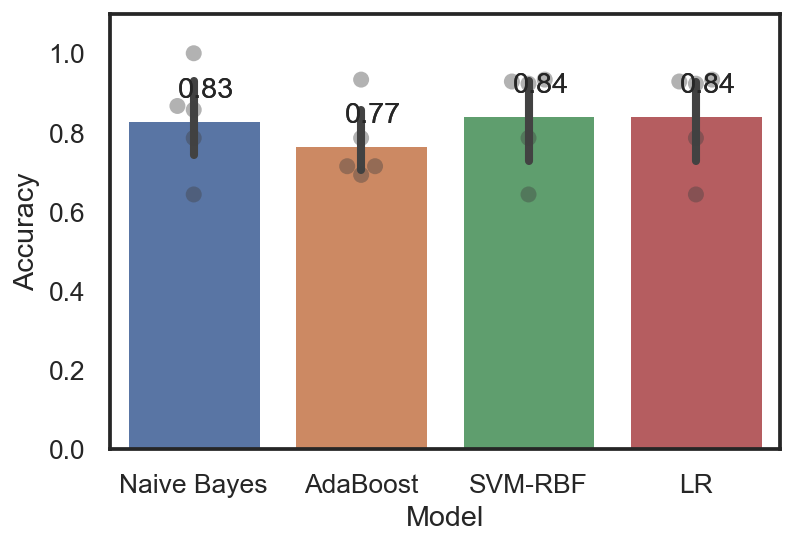

In [ ]:
ACC_fig = {'Model': ['Naive Bayes', 'AdaBoost', 'SVM-RBF', 'LR'], 
               'Accuracy':[mean(NB_ACC), mean(ADA_ACC), mean(clf_ACC), mean(LR_ACC)]}

afig = {'Naive Bayes': NB_ACC, 'AdaBoost': ADA_ACC, 
        'SVM': clf_ACC, 'LR': LR_ACC}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(ACC_fig, 'Accuracy');
#plt.title('ML Model Accuracy Comparison for RCC prediction');

**Precision**

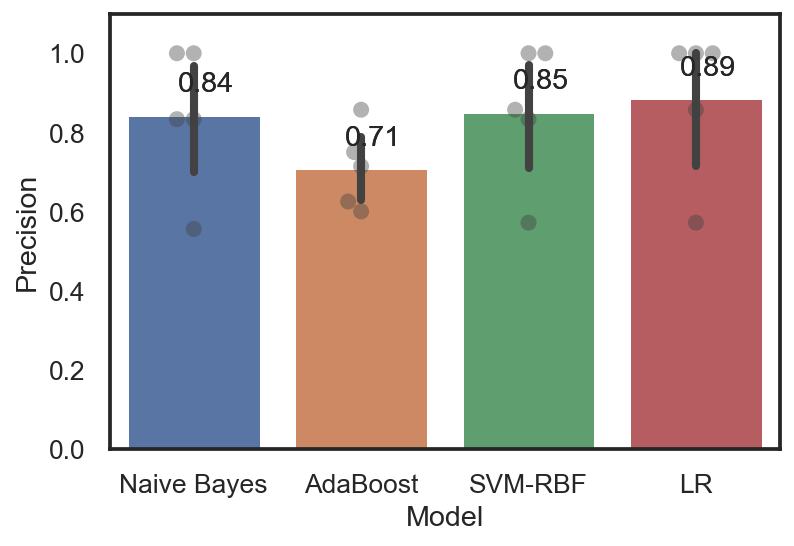

In [ ]:
PREfig = {'Model': ['Naive Bayes', 'AdaBoost', 'SVM-RBF', 'LR'], 
               'Precision':[mean(NB_PRE), mean(ADA_PRE), mean(clf_PRE), mean(LR_PRE)]}

afig = {'Naive Bayes': NB_PRE, 'AdaBoost': ADA_PRE, 
        'SVM': clf_PRE, 'LR': LR_PRE}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(PREfig, 'Precision');
#plt.title('ML Model Sensitivity (Precision) Comparison for RCC prediction');

**Recall**

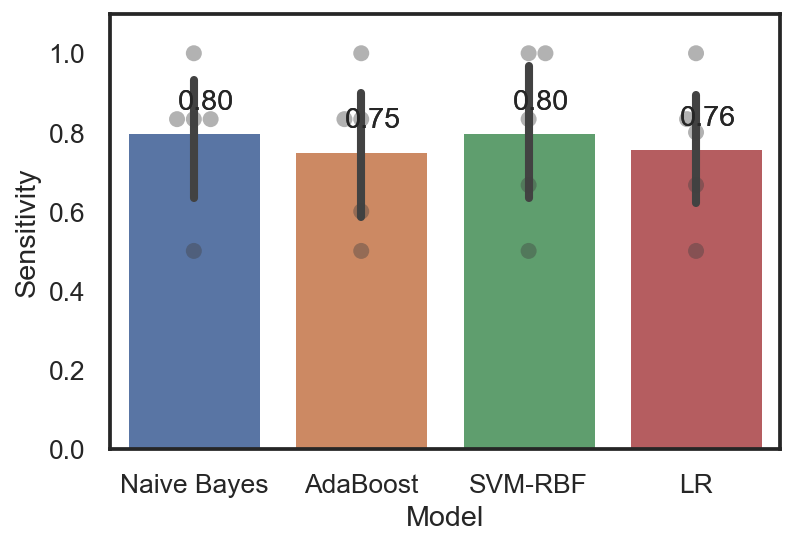

In [ ]:
RECfig = {'Model': ['Naive Bayes', 'AdaBoost', 'SVM-RBF', 'LR'], 
               'Sensitivity':[mean(NB_REC), mean(ADA_REC), mean(clf_REC), mean(LR_REC)]}

afig = {'Naive Bayes': NB_REC, 'AdaBoost': ADA_REC, 
        'SVM-RBF': clf_REC, 'LR': LR_REC}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(RECfig, 'Sensitivity');
#plt.title('ML Model Specificity (Recall) Comparison for RCC prediction');

**F1 Score**

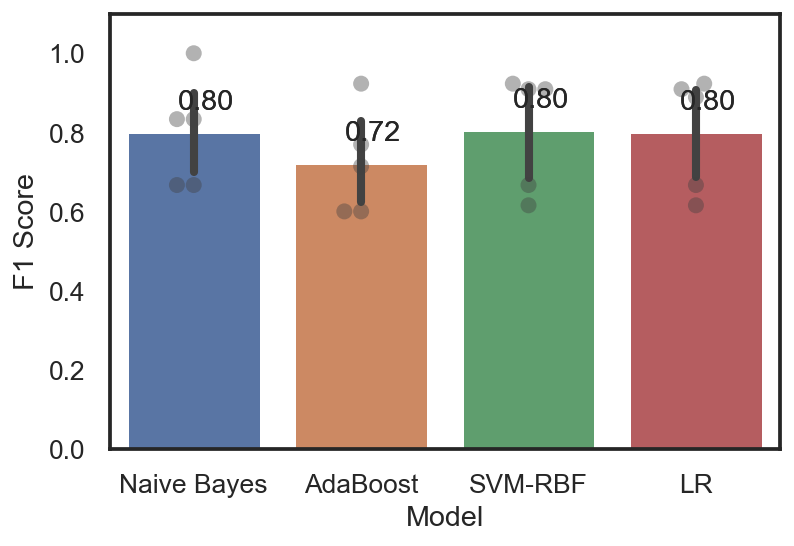

In [ ]:
RECfig = {'Model': ['Naive Bayes', 'AdaBoost', 'SVM-RBF', 'LR'], 
               'F1 Score':[mean(NB_FS), mean(ADA_FS), mean(clf_FS), mean(LR_FS)]}

afig = {'Naive Bayes': NB_FS, 'AdaBoost': ADA_FS, 
        'SVM-RBF': clf_FS, 'LR': LR_FS}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(RECfig, 'F1 Score');
#plt.title('ML Model F1 Score Comparison for RCC prediction');

**Specificity**

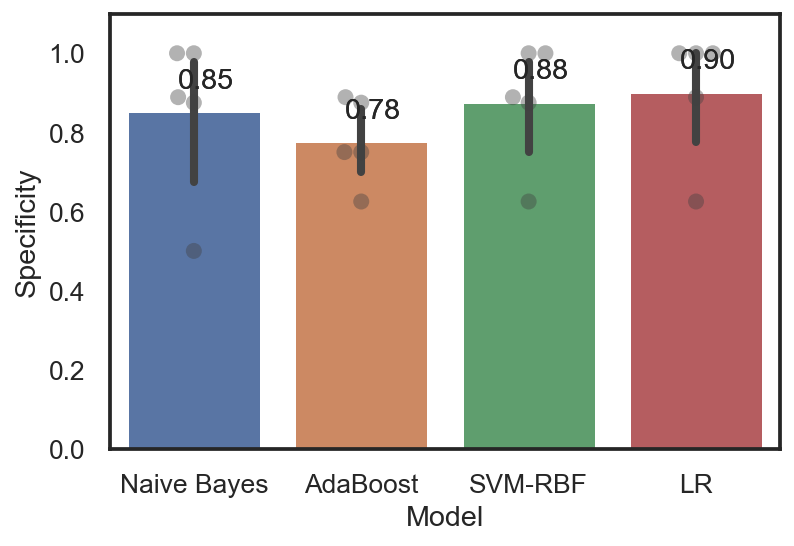

In [ ]:
SPEfig = {'Model': ['Naive Bayes', 'AdaBoost', 'SVM-RBF', 'LR'], 
               'Specificity':[mean(NB_SPE), mean(ADA_SPE), mean(clf_SPE), mean(LR_SPE)]}

afig = {'Naive Bayes': NB_SPE, 'AdaBoost': ADA_SPE, 
        'SVM-RBF': clf_SPE, 'LR': LR_SPE}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(SPEfig, 'Specificity');
#plt.title('ML Model F1 Score Comparison for RCC prediction');

 ## 4. RCC Stage Potential Biomarkers: PCA, HCA, Boxplot Visualization
 <a id="4"></a>

In [ ]:
group_loc = RCCdataframe.columns.get_loc("Grouped Stage") #location of grouped stage.
biomarker =  RCCdataframe.iloc[:, group_loc].to_frame().join(MLfeatures)

In [ ]:
MS_labels[MS_labels.ID.isin(final_features)]['Name']

247                                                248
1371                              4-Guanidinobutanoate
1903                      7-Aminomethyl-7-deazaguanine
2121                Nalpha_Nalpha-Dimethyl-L-histidine
2316                    Diethyl2-methyl-3-oxosuccinate
2464                  1-Carbapen-2-em-3-carboxylicacid
3162                                              3163
3765                                     L-Indospicine
4115                                              4116
5044                                              5045
5407    1-(beta-D-Ribofuranosyl)-1,2-dihydropyrimidine
5419                                              5420
5436                                              5437
5712                                              5713
5736                                           Gly-Lys
5984                                              5985
6686                                              6687
6693                                              6694
Name: Name

**p-values for biomarkers**

In [ ]:
stat_sig[stat_sig.Metabolite.isin(biomarker.columns)]

,Metabolite,T-test p-value,FDR p-value,Reject H0
1431,6687,0.000577,0.116177,False
1052,4116,0.000308,0.116177,False
1214,5408,0.001037,0.155352,False
91,248,0.001300,0.177079,False
914,3163,0.001567,0.180587,False
470,1372,0.001696,0.181420,False
671,2122,0.002328,0.217990,False
1007,3766,0.002720,0.230618,False
1253,5737,0.002884,0.230618,False
1172,5045,0.003830,0.244412,False


_rename_

In [ ]:
biomarker.rename(columns={1372 :'4-Guanidinobutanoate',
                          1904:'7-Aminomethyl-7-deazaguanine',
                          2122:'N,N-alpha-Dimethyl-L-histidine',
                          2317  :'Diethyl2-methyl-3-oxosuccinate',
                          2465:'1-Carbapen-2-em-3-carboxylicacid',
                          3766:'L-Indospicine',
                         5737:'Gly-Lys'}, 
                 inplace=True)

#### Boxplot

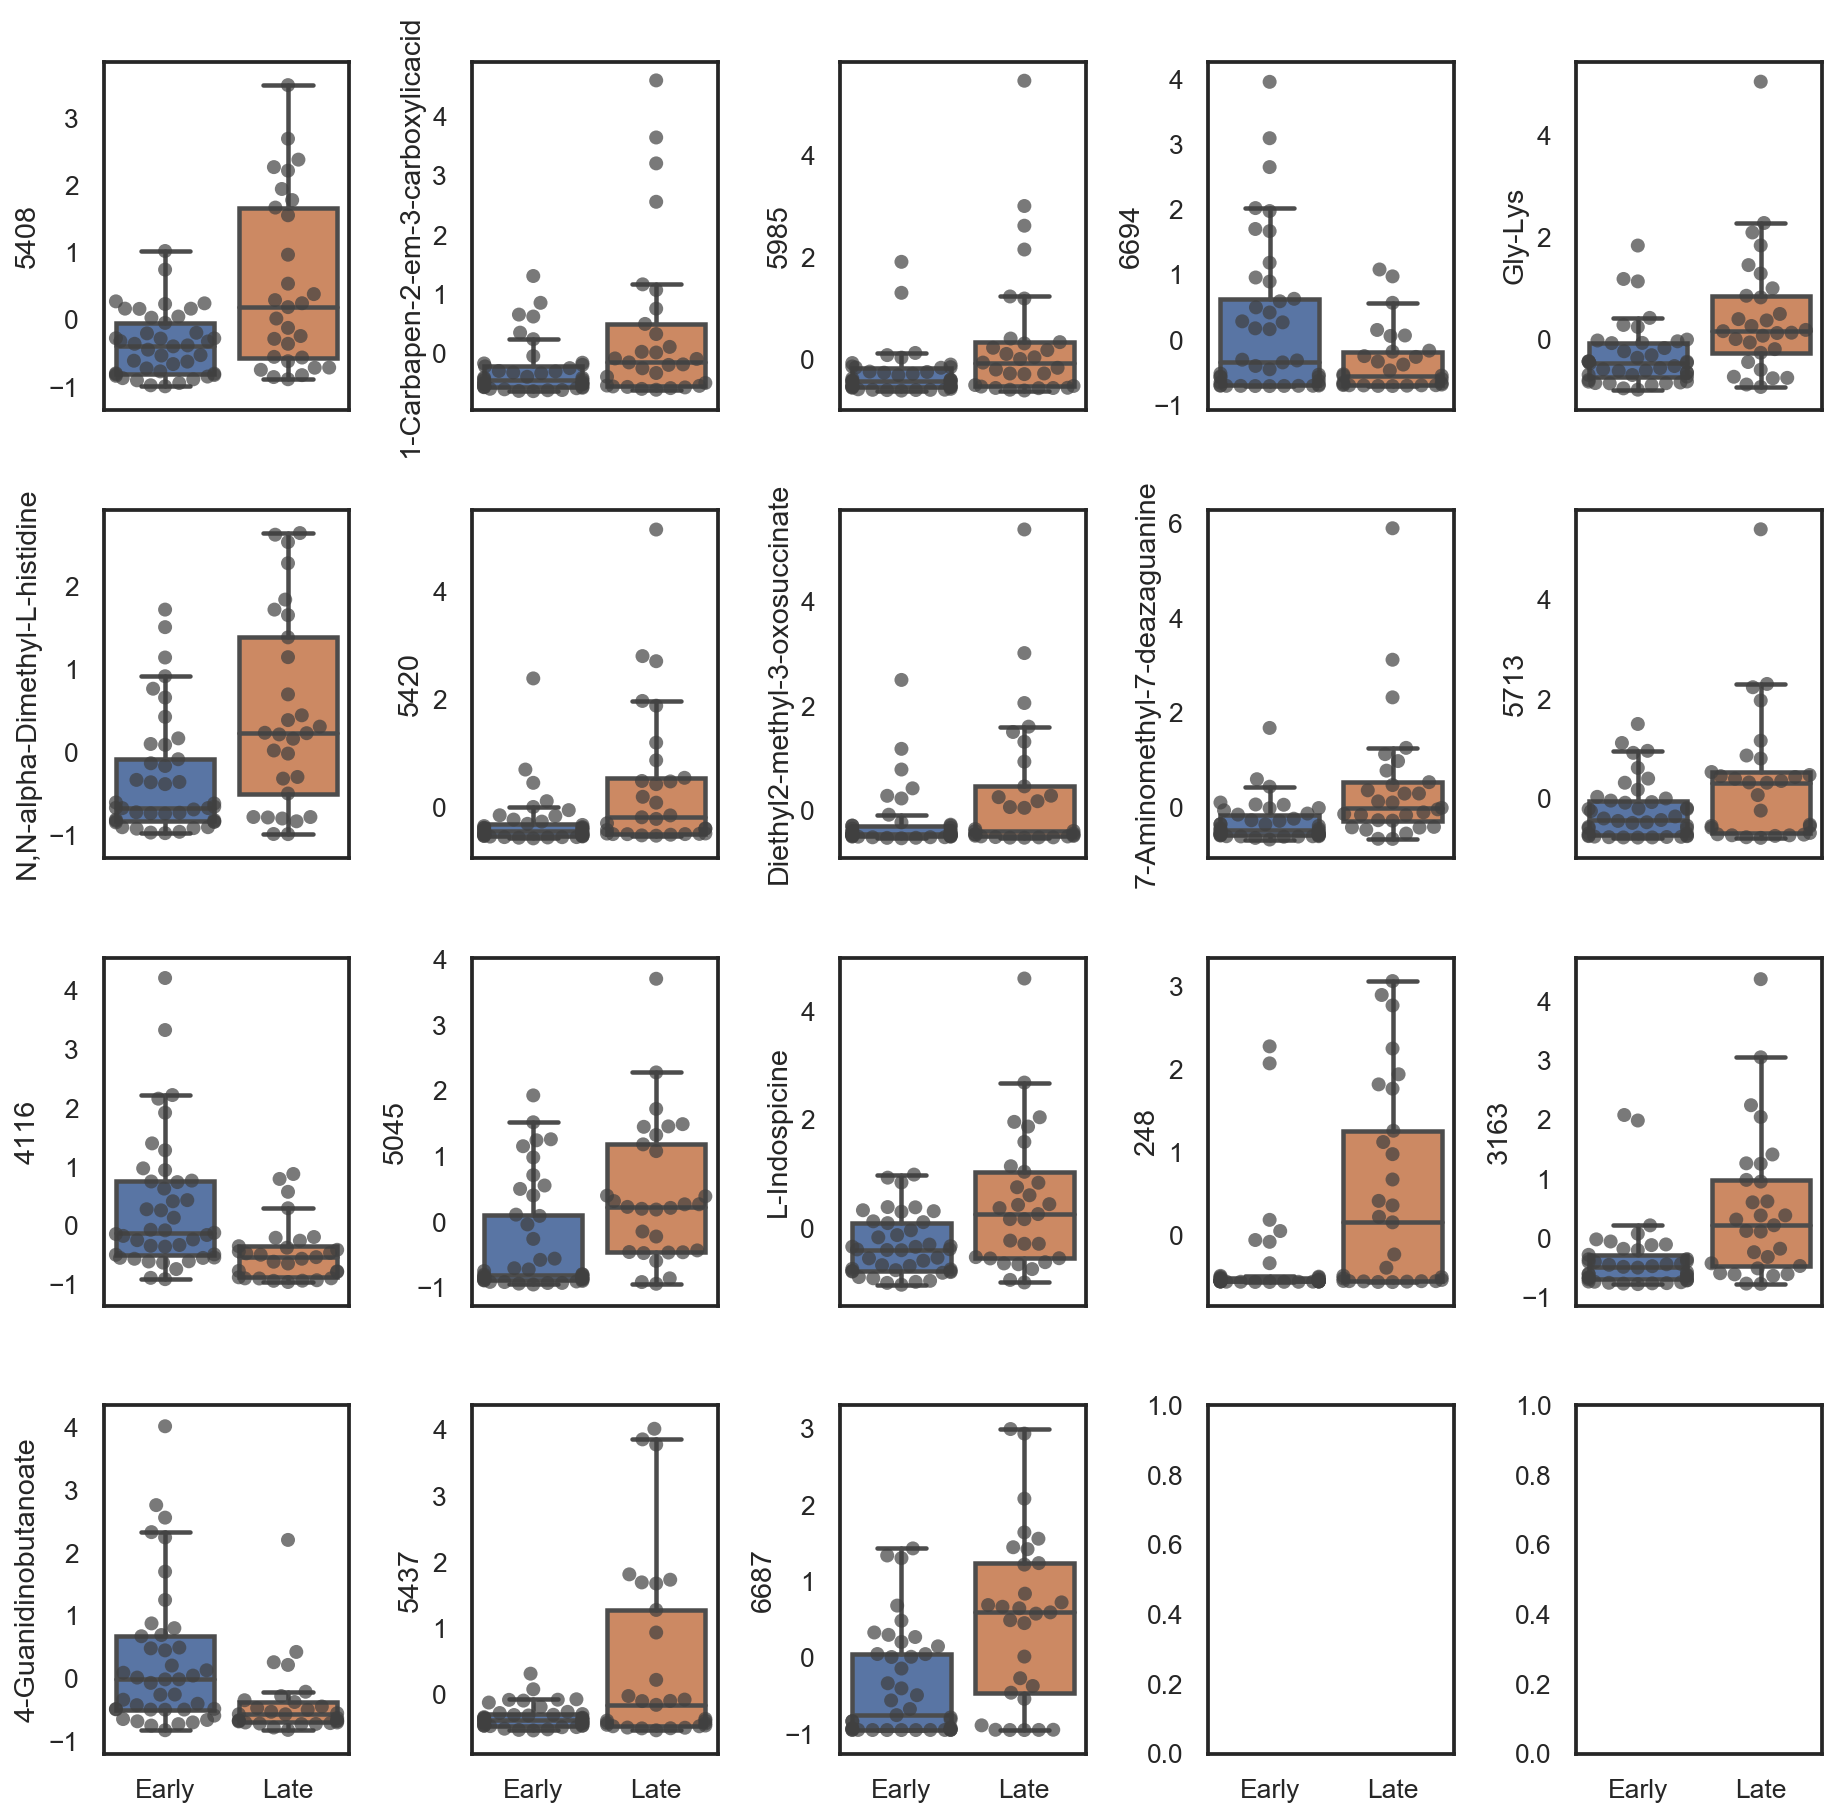

In [ ]:
# Metabolites Quantification via boxplot or barplot
fig, axes = plt.subplots(nrows=4, ncols=5, sharex=True, figsize=(13, 13))
for idx, feat in enumerate(biomarker.columns[1:]):
    ax = axes[int(idx / 5), idx % 5]
    sns.boxplot(x='Grouped Stage', y=feat, data=biomarker, 
                ax=ax, showfliers=False)
    #sns.barplot (x='Grouped Stage', y=feat, data=biomarker, ax=ax, capsize=.06)
    sns.swarmplot(x='Grouped Stage', y=feat, data=biomarker, 
                  ax=ax, s=7, alpha=0.7, color=".25");
    ax.set_xlabel('')
    ax.set_ylabel(feat) #feat
fig.tight_layout();
#plt.savefig('AUCplots.svg', dpi=300)

_PCA Function_

In [ ]:
def PCA_Python(X, y, Group1, Group2, scaled=True):
    '''
    FUNCTION:  
    A principle component analysis function
    Note that number of component to be picked is fixed at 2 and scaling is pareto. 
    **Edit function to make this flexible** 
    
    DEPENDENCY: sklearn
    from sklearn import decomposition
    
    INPUT: Pandas dataframe
    X: Data. Numerical.
    y: Groups
    Group1: String. Name of first group.
    Group2: String. Name of second group.
    scaled: Boolean. Default=True
   
    
    OUTPUT: figure
    A PCA score plot
    
    '''
    pca = decomposition.PCA(n_components=2)
    if scaled == True: 
        X_centered = (X - X.mean(axis=0))/np.sqrt(X.std(axis=0)) # pareto scaling.
    elif scaled == False:
        X_centered = X
    
    pca.fit(X_centered)
    X_pca = pca.transform(X_centered)
    Var = pca.explained_variance_ratio_ # returns variance ratio of the selected component. 
    a = plt.plot(X_pca[y == 0, 0], X_pca[y == 0, 1], 'bo', label=Group1);
    b = plt.plot(X_pca[y == 1, 0], X_pca[y == 1, 1], 'ro', label=Group2);
    c = plt.xlabel("PC1: " + str(round(Var[0]*100, 2)) + "%");
    d = plt.ylabel("PC2: " + str(round(Var[1]*100, 2))+ "%");
    e = plt.legend(loc=0);
    return (a, b, c, d, e)

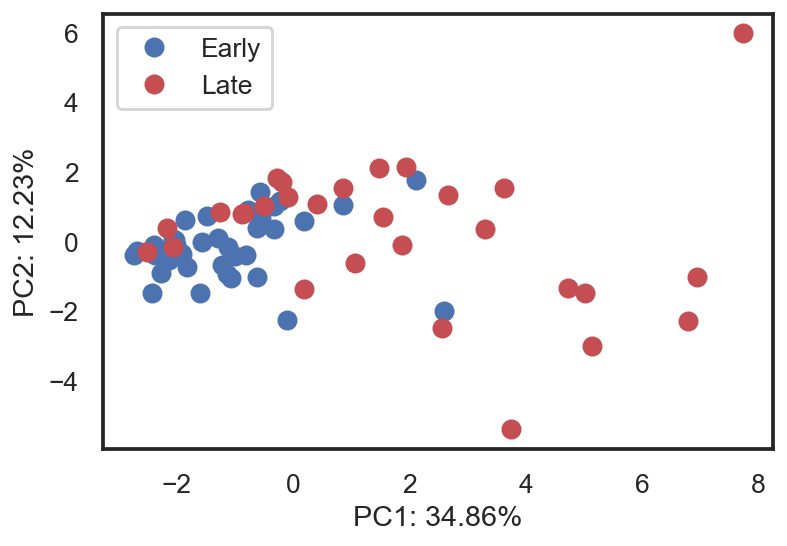

In [ ]:
stagedata = RCCdataframe[MLfeatures.columns]
stagedata =(stagedata - stagedata.mean(axis=0))/stagedata.std(axis=0) #autoscaling
classes = RCCdataframe['Grouped Stage'].map({'Early': 0, 'Late': 1}) 
PCA_Python(stagedata, classes, 'Early', 'Late', scaled=True);

In [ ]:
def PCA_Python3D(X, y, scaled=True):
    '''
    FUNCTION:  
    A principle component analysis function
    Note that number of component to be picked is fixed at 2 and scaling is pareto. 
    **Edit function to make this flexible** 
    
    DEPENDENCY: sklearn
    from sklearn import decomposition
    
    INPUT: Pandas dataframe
    X: Data. Numerical.
    y: Groups
    scaled: Boolean. Default=True
   
    
    OUTPUT: figure
    A PCA score plot
    
    '''
    pca = decomposition.PCA(n_components=3)
    if scaled == True:
        X_centered = (X - X.mean(axis=0))/np.sqrt(X.std(axis=0)) # pareto scaling.
        #X_centered =(X - X.mean(axis=0))/X.std(axis=0) #autoscaling
    elif scaled == False:
        X_centered = X
    
    pca.fit(X_centered)
    X_pca = pca.transform(X_centered)
    Var = pca.explained_variance_ratio_ # returns variance ratio of the selected component.
    #plt.title('PCA Score plot for Molecular Descriptors');
    ax=plt.figure(figsize=(16,10)).gca(projection='3d')
    ax.scatter(
        xs=X_pca[:,0],
        ys=X_pca[:,1],
        zs=X_pca[:,2],
        s=50, c=y,
        cmap="bwr"
    )
    
    return ax, Var

In [ ]:
(ax, pcaVa) = PCA_Python3D(stagedata, list(classes), scaled=True)


ax.set_xlabel('PC1:'+str(round(pcaVa[0]*100, 2)) + "%")
ax.set_ylabel('PC2:'+str(round(pcaVa[1]*100, 2)) + "%")
ax.set_zlabel('PC3:'+str(round(pcaVa[2]*100, 2)) + "%")
#ax.legend(["Early RCC", "Late RCC"])
ax.legend(['Early RCC'])
plt.show()

ValueError: Unknown projection '3d'

<Figure size 1152x720 with 0 Axes>

_Hierarachial Clustering_

In [ ]:
MLfeatures =(MLfeatures - MLfeatures.mean(axis=0))/MLfeatures.std(axis=0) #autoscaling
# index of grouped stage in RCCdataframe
stage_loc = RCCdataframe.columns.get_loc("Grouped Stage") 
# marker is the dataframe for our boxplot
stagedata = RCCdataframe.iloc[:, stage_loc].to_frame().join(MLfeatures).dropna()

In [ ]:
groups_two = stagedata.pop('Grouped Stage')
lut = dict(zip(groups_two.unique(), 'rbg'))
row_colors = groups_two.map(lut)
sns.clustermap(stagedata, method="weighted", 
                   metric='euclidean', cmap="viridis", row_cluster=True, 
                   row_colors=row_colors, robust=True);
# define biomarker dataframe again because of the .pop method
MLfeatures =(MLfeatures - MLfeatures.mean(axis=0))/MLfeatures.std(axis=0) #autoscaling
stage_loc = RCCdataframe.columns.get_loc("Grouped Stage") 
stagedata = RCCdataframe.iloc[:, stage_loc].to_frame().join(MLfeatures).dropna()

## 5. Patient Cohort Characteristics and Confounder Analysis
 <a id="5"></a>

**Collection Method**

In [ ]:
stagedata = RCCdataframe[MLfeatures.columns]
stagedata =(stagedata - stagedata.mean(axis=0))/stagedata.std(axis=0) #autoscaling
classes = RCCdataframe['Collection'].map({'Clinic': 0, 'OR': 1}) 
PCA_Python(stagedata, classes, 'Clinic', 'OR', scaled=True);

In [ ]:
(ax, pcaVa) = PCA_Python3D(stagedata, list(classes), scaled=True)


ax.set_xlabel('PC1:'+str(round(pcaVa[0]*100, 2)) + "%")
ax.set_ylabel('PC2:'+str(round(pcaVa[1]*100, 2)) + "%")
ax.set_zlabel('PC3:'+str(round(pcaVa[2]*100, 2)) + "%")
#ax.legend(["Early RCC", "Late RCC"])
ax.legend((0, 1), ("Early RCC", "Late RCC"))
plt.show()

**Gender**

In [ ]:
stagedata = RCCdataframe[MLfeatures.columns]
stagedata =(stagedata - stagedata.mean(axis=0))/stagedata.std(axis=0) #autoscaling
classes = RCCdataframe['Gender'].map({'Male': 0, 'Female': 1}) 
PCA_Python(stagedata, classes, 'Male', 'Female', scaled=True);

In [ ]:
(ax, pcaVa) = PCA_Python3D(stagedata, list(classes), scaled=True)


ax.set_xlabel('PC1:'+str(round(pcaVa[0]*100, 2)) + "%")
ax.set_ylabel('PC2:'+str(round(pcaVa[1]*100, 2)) + "%")
ax.set_zlabel('PC3:'+str(round(pcaVa[2]*100, 2)) + "%")
#ax.legend(["Early RCC", "Late RCC"])
ax.legend((0, 1), ("Early RCC", "Late RCC"))
plt.show()

In [ ]:
# Proportion of genders. 
dEarly = RCCdataframe[(RCCdataframe['Grouped Stage'] == 'Early')]
dLate = RCCdataframe[(RCCdataframe['Grouped Stage'] == 'Late')]
print(dEarly['Gender'].value_counts())
print(dEarly['Gender'].value_counts(normalize=True)*100)
print(dLate['Gender'].value_counts())
print(dLate['Gender'].value_counts(normalize=True)*100)

**Smoker**

In [ ]:
stagedata = RCCdataframe[MLfeatures.columns]
stagedata =(stagedata - stagedata.mean(axis=0))/stagedata.std(axis=0) #autoscaling
classes = RCCdataframe['Smoker'].map({'Never': 0, 'Former': 1, 'Current': 1}) 
PCA_Python(stagedata, classes, 'Never', 'Former/Current', scaled=True);

In [ ]:
(ax, pcaVa) = PCA_Python3D(stagedata, list(classes), scaled=True)


ax.set_xlabel('PC1:'+str(round(pcaVa[0]*100, 2)) + "%")
ax.set_ylabel('PC2:'+str(round(pcaVa[1]*100, 2)) + "%")
ax.set_zlabel('PC3:'+str(round(pcaVa[2]*100, 2)) + "%")
#ax.legend(["Early RCC", "Late RCC"])
ax.legend((0, 1), ("Early RCC", "Late RCC"))
plt.show()

In [ ]:
#Proportion of smokers 

# Merge former and current smokers 
dEarly['Smoker'].replace({'Current': 'Former/Current', 'Former': 'Former/Current'}, 
                        inplace=True);
dLate['Smoker'].replace({'Current': 'Former/Current', 'Former': 'Former/Current'}, 
                        inplace=True);
print(dEarly['Smoker'].value_counts())
print(dEarly['Smoker'].value_counts(normalize=True)*100)
print(dLate['Smoker'].value_counts())
print(dLate['Smoker'].value_counts(normalize=True)*100)

**Race**

In [ ]:
print(dEarly['Race'].value_counts())
print(dEarly['Race'].value_counts(normalize=True)*100)
print(dLate['Race'].value_counts())
print(dLate['Race'].value_counts(normalize=True)*100)

**SubTypes**

In [ ]:
print(dEarly['SubTypes'].value_counts())
print(dEarly['SubTypes'].value_counts(normalize=True)*100)
print(dLate['SubTypes'].value_counts())
print(dLate['SubTypes'].value_counts(normalize=True)*100)

**Nuclear Grades**

In [ ]:
print(dEarly['Nuclear Grade'].value_counts())
print(dEarly['Nuclear Grade'].value_counts(normalize=True)*100)
print(dLate['Nuclear Grade'].value_counts())
print(dLate['Nuclear Grade'].value_counts(normalize=True)*100)

**Stage**

In [ ]:
print(dEarly['Stage'].value_counts())
print(dEarly['Stage'].value_counts(normalize=True)*100)
print(dLate['Stage'].value_counts())
print(dLate['Stage'].value_counts(normalize=True)*100)

_T-test Quantitative Cohort Characteristics_

In [ ]:
def cohortQuant(cohortID, dfControl, dfTreat, alpha=0.05, var=True):
    '''
    Function conducts a T-test for the numerical cohort characteristics between two groups
    
    Inputs: 
    cohortID = A list of the numerical cohort characteristics
    dfControl = A pandas dataframe containing the control group cohort data
    dfTreat =  A pandas dataframe containing the treatment group cohort data
    alpha = alpha for statistical significant judgment, Default 0.05
    var = If True (default), perform a standard independent 2 sample test that assumes 
    equal population variances [1]. If False, perform Welch’s t-test, which does not 
    assume equal population variance
    
    Outputs: A pandas dataframe with p-values of numerical cohort characteristics. 
    
    '''
    pvaluelist = []
    commentlist = []
    for conf in cohortID:
        statistic, pvalue = scipy.stats.ttest_ind(dfControl[conf], dfTreat[conf], 
                                              equal_var=var)
        pvaluelist.append(pvalue)
        if pvalue > alpha:
            comment = 'not significant'
        else:
            comment = 'significant'
        commentlist.append(comment)
    ConfTable = pd.DataFrame({'Confounder': cohortID, 
                              'T-test p-value': pvaluelist, 
                              'Comment': commentlist})
    return ConfTable

_Age and BMI_

In [ ]:
RCCdataframe['Grouped Stage'].value_counts()

In [ ]:
confounderID = ['Age', 'BMI']
dEarly = RCCdataframe[(RCCdataframe['Grouped Stage'] == 'Early')]
dLate = RCCdataframe[(RCCdataframe['Grouped Stage'] == 'Late')]
cohortQuant(confounderID, dEarly, dLate, var=False)

In [ ]:
print('Early RCC', dEarly.filter(['Age', 'BMI'], axis=1).describe())
print('Late RCC', dLate.filter(['Age', 'BMI'], axis=1).describe())

In [ ]:
_, axes = plt.subplots(1, 2, sharey=False, figsize=(10, 4))

Age = sns.boxplot(x='Grouped Stage', y='Age', data=RCCdataframe, ax=axes[0]);
sns.swarmplot(x='Grouped Stage', y='Age', data=RCCdataframe, s =7, alpha=0.7, color=".25", ax=axes[0])
BMI = sns.boxplot(x='Grouped Stage', y='BMI', data=RCCdataframe, ax=axes[1]);
sns.swarmplot(x='Grouped Stage', y='BMI', data=RCCdataframe, s =7, alpha=0.7, color=".25", ax=axes[1])
Age.set_title('p=0.62',loc='center');
BMI.set_title('p=0.15',loc='center');

## Chemical Information of Biomarkers

### ~170 Biomarkers

In [ ]:
Feature = stat_sig['Metabolite'].values.tolist(); # stat MS significant metabolites
# qfeatures (> 2fold 0.05>q-values)
qfeatures = RCCdataframe[Feature]
qfeatures.shape

(70, 171)

In [ ]:
MS_labels_qmarkers = MS_labels[MS_labels.ID.isin(qfeatures.columns)]
print(MS_labels_qmarkers.shape)
MS_labels_qmarkers.head()

(171, 5)


,ID,Mode,RT [min],Name,Formula
49,50,positive,3.784,Betaine,C5 H11 N O2
226,227,positive,3.393,O-Desmethyltramadol,C15 H23 N O2
247,248,positive,5.127,248,NaN
367,368,positive,1.483,Oxybenzone,C14 H12 O3
627,628,positive,1.660,capuride,C9 H18 N2 O2


In [ ]:
# save excel.
# MS_labels_qmarkers.to_excel('RCCStage_171qmarkers.xlsx')

### ~18 Biomarkers

In [ ]:
MS_labels_bmarkers = MS_labels[MS_labels.ID.isin(MLfeatures.columns)]
print(MS_labels_bmarkers.shape)
MS_labels_bmarkers.head()

(18, 5)


,ID,Mode,RT [min],Name,Formula
247,248,positive,5.127,248,NaN
1371,1372,positive,3.941,4-Guanidinobutanoate,C5 H11 N3 O2
1903,1904,positive,4.004,7-Aminomethyl-7-deazaguanine,C7 H9 N5 O
2121,2122,positive,1.209,Nalpha_Nalpha-Dimethyl-L-histidine,C8 H13 N3 O2
2316,2317,positive,0.892,Diethyl2-methyl-3-oxosuccinate,C9 H14 O5


In [ ]:
MLfeatures.shape

(70, 18)

In [ ]:
# save excel.
#MS_labels_bmarkers.to_excel('RCCStage_18markers.xlsx')